In [85]:
# Download important libraries
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)
import json
import os
from os import path
import tarfile
import sparknlp
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import array_contains
from sparknlp.annotator import *
from sparknlp.common import RegexRule
from sparknlp.base import DocumentAssembler, Finisher
from pyspark.sql.functions import udf
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import regexp_replace, col
from functools import reduce
pipeline=None
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

In [20]:
spark = sparknlp.start(gpu=True) 
spark

In [159]:
def clean_df(df):
    df = df[df.caption != '']
    return df.reset_index(drop=True)

In [201]:
st_time = time.time()
rev_dpath = '../data/outputs/reviews/'
        
rev_files = [rev_dpath+ f for f in os.listdir(rev_dpath)]
folds = len(rev_files)//2000
for i in range(folds)[1:]:
    parq_dpath = '../data/spark/reviews/'
    parq_fname = '../data/spark/reviews/review_fold_' + str(i) + '.parq'
    parq_files = [parq_dpath+ f for f in os.listdir(parq_dpath)]
    if parq_fname not in parq_files[:-1]:
        df_rev = pd.DataFrame()
        if i*2000 < len(rev_files):
            rev_files_fold = rev_files[i*2000:(i+1)*2000]
        else:
            rev_files_fold = rev_files[i*2000:]
        for file in rev_files_fold:

            df = pd.read_json(file)

            df['place_id'] = file.split('_',1)[1]
            df['place_id'] = df['place_id'].str.replace('.json','')
            df_rev = pd.concat((df_rev, df), ignore_index=True)

        df_rev.to_parquet(parq_fname)
        print('Fold ',str(i), ' Done. Time Taken = ',time.time()-st_time)
    

Fold  3  Done. Time Taken =  333.55541253089905
Fold  4  Done. Time Taken =  666.4528720378876


In [202]:
df_reviews = pd.DataFrame()
rev_parq_dir = '../data/spark/reviews/'
parq_files = [rev_parq_dir+ f for f in os.listdir(rev_parq_dir) if os.path.isfile(rev_parq_dir+ f)]
df_review = pd.DataFrame()
for file in parq_files:
    df_fold = pd.read_parquet(file)
    df_review = pd.concat((df_review, df_fold), ignore_index=True)
df_review = clean_df(df_review)
df_review = df_review.drop_duplicates(subset = ['id_review'], keep='first')
df_review.sample(2)

,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,census_block_group,place_id
806753,ChdDSUhNMG9nS0VJQ0FnSURpZ3FHeV9nRRAB,I’m so happy I found this place!!! I’ve been l...,4 months ago,2021-04-01,5,Biata Krukover,1,0,https://www.google.com/maps/contrib/1133440385...,360470021002,ChIJ0yortrJbwokRATW7F2DeED0
43543,ChdDSUhNMG9nS0VJQ0FnSURZdDRHbTBBRRAB,"Always a good time, they do get packed and the...",a year ago,2021-03-23,5,Vanessa A,0,0,https://www.google.com/maps/contrib/1021299161...,110010044002,ChIJgSkWc-W3t4kRGPYlTbHAJe4


In [204]:
df_rest = pd.read_parquet('../data/spark/restaurants/restaurants.parq')
df_rest = df_rest.drop_duplicates(subset = ['place_id'], keep='first')
df_rest.sample(2)

,business_status,geometry,icon,name,opening_hours,photos,place_id,plus_code,reference,scope,types,vicinity,rating,user_ratings_total,CBG,Radius,price_level,permanently_closed
18428,OPERATIONAL,"{'location': {'lat': 32.782596, 'lng': -96.794...",https://maps.gstatic.com/mapfiles/place_api/ic...,TRUE Kitchen + Kocktails,{'open_now': False},"[{'height': 3024, 'html_attributions': ['<a hr...",ChIJE-rQvPWZToYRe0HhJuoEHNo,"{'compound_code': 'Q6M4+24 Dallas, TX, USA', '...",ChIJE-rQvPWZToYRe0HhJuoEHNo,GOOGLE,"[restaurant, food, point_of_interest, establis...","1933 Elm Street, Dallas",4.2,422.0,481130031011,387.864233,NaN,NaN
14046,OPERATIONAL,"{'location': {'lat': 40.8551498, 'lng': -73.93...",https://maps.gstatic.com/mapfiles/place_api/ic...,Fort Tyron Grill,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJ7S77paf2wokRCrjAy5h4GY4,"{'compound_code': 'V346+3Q New York, NY, USA',...",ChIJ7S77paf2wokRCrjAy5h4GY4,GOOGLE,"[restaurant, food, point_of_interest, establis...","210 Pinehurst Avenue, New York",4.8,9.0,360610275001,270.734001,NaN,NaN


rev_dpath = '../data/outputs/cbg_restaurants/'
        
rev_files = [rev_dpath+ f for f in os.listdir(rev_dpath)][:-1]
df_rest = pd.DataFrame()
for file in rev_files:
    
    df = pd.read_json(file)

    df_rest = pd.concat((df_rest, df), ignore_index=True)
df_rest.to_parquet('../data/spark/reviews/restaurants.parq')
df_rest = df_rest.drop_duplicates(subset = ['place_id'], keep='first')


In [211]:
df_merge = df_review.join(df_rest.set_index('place_id'), on='place_id', rsuffix= '_restaurant',how='inner')

df_merge.sample(2)

,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,census_block_group,...,reference,scope,types,vicinity,rating_restaurant,user_ratings_total,CBG,Radius,price_level,permanently_closed
11887,ChdDSUhNMG9nS0VJQ0FnSUNBdEtTT3d3RRAB,The worst of the worst. I just called to orde...,3 years ago,2021-03-23,1,Anonymous Gaming Beserk,8,0,https://www.google.com/maps/contrib/1042255053...,110010018042,...,ChIJX3LLIWLIt4kR0PiUA756jPY,GOOGLE,"[meal_delivery, restaurant, food, point_of_int...","6215 Georgia Avenue Northwest, Washington",3.5,48.0,110010018042,269.739270,1.0,NaN
159267,ChdDSUhNMG9nS0VJQ0FnSUN3MU9DaTBRRRAB,A great old world bakery with fine service,3 years ago,2021-03-25,4,Robert Russ,1,0,https://www.google.com/maps/contrib/1007573762...,120570048002,...,ChIJJ1tmaHbDwogRxB86-j_tUjw,GOOGLE,"[bakery, restaurant, food, point_of_interest, ...","2909 West Cypress Street, Tampa",4.5,693.0,120570048002,380.283032,2.0,NaN


In [212]:
def clean_merge(df):
    df = df[df.caption.str.len() > 25]
    df.caption = df.caption.replace('(Translated by Google)','')
    df.caption = df.caption.replace('(Original)','')
    return df

In [223]:
df_merge_clean = clean_merge(df_merge)
print(df_merge_clean.size)
df_merge_clean.sample(2)

22344784


,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,census_block_group,...,reference,scope,types,vicinity,rating_restaurant,user_ratings_total,CBG,Radius,price_level,permanently_closed
594830,ChZDSUhNMG9nS0VJQ0FnSUNVN2I2Z2J3EAE,Not the easiest place to get to by car but onc...,a year ago,2021-03-29,5,snathanm427,0,0,https://www.google.com/maps/contrib/1056949112...,220710135003,...,ChIJw-JSixGmIIYR0_4fo_kybQw,GOOGLE,"[restaurant, food, point_of_interest, establis...","620 Chartres Street, New Orleans",4.7,614.0,220710135003,261.205763,4.0,NaN
529645,ChZDSUhNMG9nS0VJQ0FnSUNJNFp1ekJ3EAE,Tin roof is a fun chill bar in Indy that often...,2 years ago,2021-03-29,4,Shelby Shepherd,0,0,https://www.google.com/maps/contrib/1183720774...,180973910003,...,ChIJexEho71Qa4gRN_19ml4q-OE,GOOGLE,"[bar, restaurant, food, point_of_interest, est...","36 South Pennsylvania Street, Indianapolis",4.0,768.0,180973910003,1009.458466,1.0,NaN


In [217]:
# df_merge_clean = df_merge_clean[df_merge_clean['rating']!=3]
# print(df_merge_clean.size)

20695220


In [224]:
def sentiment(x):
    if x<=3:
        return 0
    return 1

In [225]:
df_merge_clean['sentiment'] = df_merge_clean['rating'].apply(lambda x: sentiment(x))

In [228]:
tf.config.list_physical_devices('GPU')

[]

<AxesSubplot:>

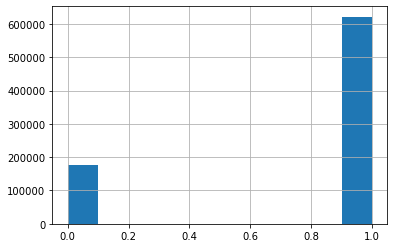

In [226]:
df_merge_clean['sentiment'].hist()

In [132]:
from pyspark.sql.functions import regexp_replace, col

trainDataset = spark.read.option("header", True).parquet('../data/spark/reviews/test.parq').select(col("caption"),col("rating"))
trainDataset = trainDataset.withColumn("caption", regexp_replace(("caption"), "(Translated by Google)", ""))
df = trainDataset.repartition(1)
trainDataset.show(10)
df_filtered=df.filter(df.caption !='')
df_filtered = df_filtered.withColumn("rating", col("rating").cast("string"))

+--------------------+------+
|             caption|rating|
+--------------------+------+
|One of my new fav...|     5|
|I got the Peanut ...|     5|
|Love this place! ...|     5|
|Everything is Ama...|     5|
|The bacon, egg, a...|     5|
|We really like th...|     5|
|Quick service, ta...|     5|
|Best BBQ...even b...|     5|
|So nice the break...|     5|
|Best place for br...|     5|
+--------------------+------+
only showing top 10 rows



In [133]:

df_filtered.groupBy("rating") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+------+------+
|rating| count|
+------+------+
|   5.0|232193|
|   4.0| 65204|
|   1.0| 30619|
|   3.0| 26711|
|   2.0| 14869|
+------+------+



In [135]:
train_df, test_df = df_filtered.randomSplit([0.8,0.2],42)
train_df.show(10)

+--------------------+------+
|             caption|rating|
+--------------------+------+
|         ! AMAZING!!|   5.0|
|! Best BBQ in the...|   5.0|
|"#MUCH_LOVE_AND_M...|   4.0|
|"A 3rd Place wher...|   5.0|
|"A must have when...|   5.0|
|"Amazing food, gr...|   5.0|
|"Best meal,  expe...|   5.0|
|"Best place to ea...|   5.0|
|"Best wings in th...|   5.0|
|"Big easy" noodle...|   5.0|
+--------------------+------+
only showing top 10 rows



In [143]:
import pyspark.sql.types

document = DocumentAssembler()\
    .setInputCol("caption")\
    .setOutputCol("document")

# we can also use sentence detector here 
# if we want to train on and get predictions for each sentence
# downloading pretrained embeddings

embeddings = UniversalSentenceEncoder.pretrained('tfhub_use', lang="en") \
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("rating")\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)
use_clf_pipeline = Pipeline(
    stages = [
        document,
        embeddings,
        classsifierdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


IllegalArgumentException: requirement failed: Was not found appropriate resource to download for request: ResourceRequest(tfhub_use,Some(en),public/models,3.0.0,3.1.1) with downloader: com.johnsnowlabs.nlp.pretrained.S3ResourceDownloader@6956083c

In [142]:
use_pipelineModel = use_clf_pipeline.fit(df_filtered)


IllegalArgumentException: requirement failed: Wrong or missing inputCols annotators in SentenceEmbeddings_2b0176c4facf.

Current inputCols: document. Dataset's columns:
(column_name=caption,is_nlp_annotator=false)
(column_name=rating,is_nlp_annotator=false)
(column_name=document,is_nlp_annotator=true,type=document).
Make sure such annotators exist in your pipeline, with the right output names and that they have following annotator types: document, word_embeddings

In [116]:
st_time = time.time()
rev_dpath = '../data/outputs/reviews/'
        
rev_files = [rev_dpath+ f for f in os.listdir(rev_dpath)]
df_rev = pd.DataFrame()
for file in rev_files:
    
    df = pd.read_json(file)

    df_rev = pd.concat((df_rev, df), ignore_index=True)
print(time.time()-st_time)

PermissionError: [Errno 13] Permission denied: '../data/outputs/reviews/jsonl'

In [97]:
rev_files[0]

'../data/outputs/reviews/10810402004_ChIJ2Wl4t3vzjIgR0jrQX9_UoWw.json'

In [99]:
with open(rev_files[0],'r') as inp_file:
    x= json.load(inp_file)
x

[{'id_review': 'ChZDSUhNMG9nS0VJQ0FnSUN5LWZtWmZnEAE',
  'caption': 'One of my new favorite places 😋',
  'relative_date': 'a month ago',
  'retrieval_date': '2021-03-23',
  'rating': 5.0,
  'username': 'Monica Crist',
  'n_review_user': 20,
  'n_photo_user': 0,
  'url_user': 'https://www.google.com/maps/contrib/117300709159619750156/reviews?hl=en-US',
  'census_block_group': 10810402004},
 {'id_review': 'ChZDSUhNMG9nS0VJQ0FnSUQ4dTVxcWFREAE',
  'caption': 'I got the Peanut Butter Cup Shake and it was really good! Cant wait to try more flavors!',
  'relative_date': '7 months ago',
  'retrieval_date': '2021-03-23',
  'rating': 5.0,
  'username': 'Paulina White',
  'n_review_user': 0,
  'n_photo_user': 0,
  'url_user': 'https://www.google.com/maps/contrib/106425158284488465525/reviews?hl=en-US',
  'census_block_group': 10810402004},
 {'id_review': 'ChdDSUhNMG9nS0VJQ0FnSURjNXVDM25nRRAB',
  'caption': 'Love this place! I recommend the cucumber watermelon loaded tea and the cake batter shake! 

In [ ]:
st_time = time.time()
rev_dpath_jsonl = '../data/spark/reviews/jsonl/'
os.makedirs(rev_dpath_jsonl, exist_ok=True)
rev_files_jsonl = [rev_dpath_jsonl+ f for f in os.listdir(rev_dpath_jsonl)]
for file in rev_files:
    JSON_file = json.loads()
with open('output.jsonl', 'w') as outfile:
    with open
    for entry in JSON_file:
        json.dump(entry, outfile)
        outfile.write('\n')

In [115]:
st_time = time.time()
rev_dpath_jsonl = '../data/spark/reviews/jsonl/'
os.makedirs(rev_dpath_jsonl, exist_ok=True)
rev_files_jsonl = [rev_dpath_jsonl+ f for f in os.listdir(rev_dpath_jsonl)]
dataframes = map(lambda r: spark.read.json(r), rev_files_jsonl)
union = reduce(lambda df1, df2: df1.unionAll(df2), dataframes)
df = union.collect()
print(time.time()-st_time)

2404.066113471985


In [86]:
file = rev_dpath_jsonl = '../data/outputs/reviews/jsonl/10730027002_ChIJNe0mPMkbiYgR6oApk2Pt7F8.json'

spark.read.json(file).head(2)[0]

Row(caption='', census_block_group=10730027002, id_review='ChZDSUhNMG9nS0VJQ0FnSURJME52MFhBEAE', n_photo_user=0, n_review_user=0, rating=4.0, relative_date='2 years ago', retrieval_date='2021-03-23', url_user='https://www.google.com/maps/contrib/116059736436598578008/reviews?hl=en-US', username='MIGUEL BOSCAN')

In [17]:
df

DataFrame[_corrupt_record: string]